# Coherent Multiclass LRs

This notebook explains the issue of 'inconsistency' when multiple estimated one-vs-rest LRs are used for Bayesian updating in a multi-class classification problem. 

## The problem

Here's the intuition for the problem: 

We are asking the LLM (or, the literature) to estimate multiple one diagnosis vs the rest likelihood ratios (ie the likelihood if diagnosis over likelihood if not diagnosis). 

For example, consider the case where there's 3 diagnoses under consideration: It's either A, B, or C (more precisely, let's say it's 1 and only 1 of A, B, or C). This means that the pre-test probabilities must sum to 1. 

If we then gather a new piece of information, we get 3 likelihood ratios

- A vs not A (== B or C). This is LR1
- B vs not B (== A or C). This is LR2
- C vs not C (== A or B). This is LR3 

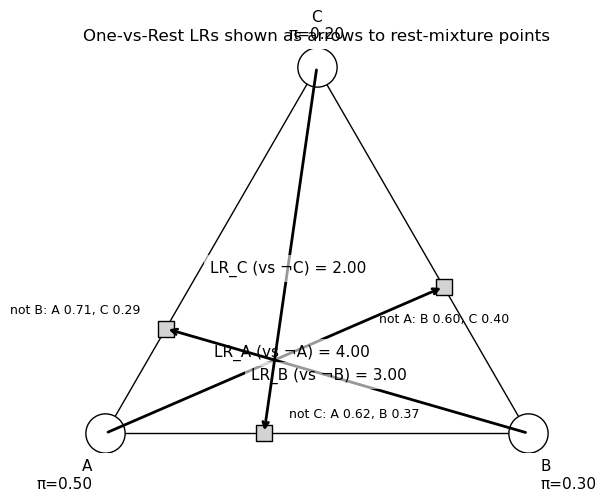

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def draw_ovr_triangle(priors=(0.5, 0.3, 0.2), lrs=(4.0, 3.0, 2.0), names=("A","B","C")):
    """
    Single-figure visualization of 3 one-vs-rest LRs.
      - Vertices: classes A, B, C
      - For each class k, compute the 'rest mixture' point on the opposite edge
        using the other classes' priors normalized by (1 - pi_k).
      - Draw an arrow from k to its opposite-edge mixture point labeled with LR_k.

    Args:
      priors: tuple/list of 3 priors (π_A, π_B, π_C) that sum to ~1
      lrs:    tuple/list of 3 OVR LRs (LR_A, LR_B, LR_C) for k vs not-k
      names:  labels for the three classes

    Notes:
      • If you have post-evidence mixture weights for "not-k", replace the
        edge-point definition accordingly. This version uses priors by default.
      • Arrows are purely illustrative of the OVR comparison; they are not Bayes updates.
    """
    # --- geometry for an equilateral triangle
    A_xy = np.array([0.0, 0.0])
    B_xy = np.array([1.0, 0.0])
    C_xy = np.array([0.5, np.sqrt(3)/2])
    V = np.stack([A_xy, B_xy, C_xy], axis=0)  # rows correspond to (A,B,C)

    def bary_to_xy(w):
        """Map barycentric weights (wA,wB,wC), sum=1, to 2D xy."""
        w = np.asarray(w, dtype=float)
        return w[0]*V[0] + w[1]*V[1] + w[2]*V[2]

    pi = np.array(priors, dtype=float)
    pi = pi / pi.sum()  # ensure normalization
    LR_A, LR_B, LR_C = lrs
    nameA, nameB, nameC = names

    # --- mixture points on opposite edges using priors
    # not-A lies on edge BC with weights proportional to (π_B, π_C)
    w_notA = np.array([0.0, pi[1]/(1-pi[0]), pi[2]/(1-pi[0])])
    w_notB = np.array([pi[0]/(1-pi[1]), 0.0, pi[2]/(1-pi[1])])
    w_notC = np.array([pi[0]/(1-pi[2]), pi[1]/(1-pi[2]), 0.0])

    P_A, P_B, P_C = A_xy, B_xy, C_xy
    M_A = bary_to_xy(w_notA)  # mixture point for "not-A" on BC
    M_B = bary_to_xy(w_notB)  # mixture point for "not-B" on AC
    M_C = bary_to_xy(w_notC)  # mixture point for "not-C" on AB

    # --- figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # triangle edges
    ax.plot([A_xy[0], B_xy[0]], [A_xy[1], B_xy[1]], 'k-', lw=1)
    ax.plot([B_xy[0], C_xy[0]], [B_xy[1], C_xy[1]], 'k-', lw=1)
    ax.plot([C_xy[0], A_xy[0]], [C_xy[1], A_xy[1]], 'k-', lw=1)

    # vertices (classes)
    ax.scatter(*A_xy, s=800, facecolor="white", edgecolor="black", zorder=3)
    ax.scatter(*B_xy, s=800, facecolor="white", edgecolor="black", zorder=3)
    ax.scatter(*C_xy, s=800, facecolor="white", edgecolor="black", zorder=3)
    ax.text(*(A_xy + np.array([-0.03, -0.06])), f"{nameA}\nπ={pi[0]:.2f}", ha="right", va="top", fontsize=11)
    ax.text(*(B_xy + np.array([ 0.03, -0.06])), f"{nameB}\nπ={pi[1]:.2f}", ha="left", va="top", fontsize=11)
    ax.text(*(C_xy + np.array([ 0.00,  0.06])), f"{nameC}\nπ={pi[2]:.2f}", ha="center", va="bottom", fontsize=11)

    # mixture points on opposite edges (small squares)
    ax.scatter(*M_A, s=120, marker='s', facecolor="lightgray", edgecolor="black", zorder=3)
    ax.scatter(*M_B, s=120, marker='s', facecolor="lightgray", edgecolor="black", zorder=3)
    ax.scatter(*M_C, s=120, marker='s', facecolor="lightgray", edgecolor="black", zorder=3)

    # annotate composition of each 'rest' (optional, comment out if you want cleaner plot)
    ax.text(*(M_A + np.array([0.00, -0.06])), f"not {nameA}: {nameB} {w_notA[1]:.2f}, {nameC} {w_notA[2]:.2f}",
            ha="center", va="top", fontsize=9)
    ax.text(*(M_B + np.array([-0.06,  0.03])), f"not {nameB}: {nameA} {w_notB[0]:.2f}, {nameC} {w_notB[2]:.2f}",
            ha="right", va="bottom", fontsize=9)
    ax.text(*(M_C + np.array([0.06,  0.03])), f"not {nameC}: {nameA} {w_notC[0]:.2f}, {nameB} {w_notC[1]:.2f}",
            ha="left", va="bottom", fontsize=9)

    # arrows from each class to its 'rest' mixture point, labeled with OVR LRs
    def arrow(p_from, p_to, label, frac=0.55):
        ax.annotate("",
            xy=p_to, xytext=p_from,
            arrowprops=dict(arrowstyle="->", lw=2, color="black"),
        )
        mid = p_from*(1-frac) + p_to*frac
        ax.text(*mid, label, fontsize=11, ha="center", va="center", bbox=dict(facecolor="white", alpha=0.6, edgecolor='none'))

    arrow(P_A, M_A, f"LR_{nameA} (vs ¬{nameA}) = {LR_A:.2f}")
    arrow(P_B, M_B, f"LR_{nameB} (vs ¬{nameB}) = {LR_B:.2f}")
    arrow(P_C, M_C, f"LR_{nameC} (vs ¬{nameC}) = {LR_C:.2f}")

    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title("One‑vs‑Rest LRs shown as arrows to rest‑mixture points", fontsize=12)
    plt.show()

# Example
draw_ovr_triangle(priors=(0.5, 0.3, 0.2), lrs=(4.0, 3.0, 2.0), names=("A","B","C"))


Because all three LRs describe how the likely probabilities change for the same patient and integrating the same piece of data, they must all be *true at once*.  And, because even after the new piece of information is incorporated, all post-test probabilities must sum to 1. 

This is called ***coherence***: when we update using the set of one-vs-rest likelihood ratios, the resulting post-test probabilities still must sum to 1, because even after the new information, there is 1 and only 1 correct answer. 

Because we have estimated each one-vs-rest (OVR) likelihood ratio (e.g. LR for A vs not A) independently and imperfectly (using the LLM, or in the case where we take it from the literature), the set of LRs may be incoherent (= when we update based on the LRs, the resulting post-test probabilities may not sum to 1).

## Naive (incorrect) solution

The naive way - and what I initially did - was to apply all the one-vs-rest likelihood ratios to update each pre-test probability, then re-scale the resulting post-test probabilities so that they sum to 1. 

This is problematic because it breaks the Bayes odds–LR identity and therefore distorts the way evidence updates the probabilities. You can see this by considering: 

When an LR of 2 is applied to a situation where the pre-test probability is 50% (1:1 odds), the post-test probability is 66% (2:1 odds) - a 16% probability difference. When an LR of 2 is applied to a situation where the pre-test probability was 90% (9:1 odds), the post-test probability is 94.7% (18:1), a less than 5% difference. 

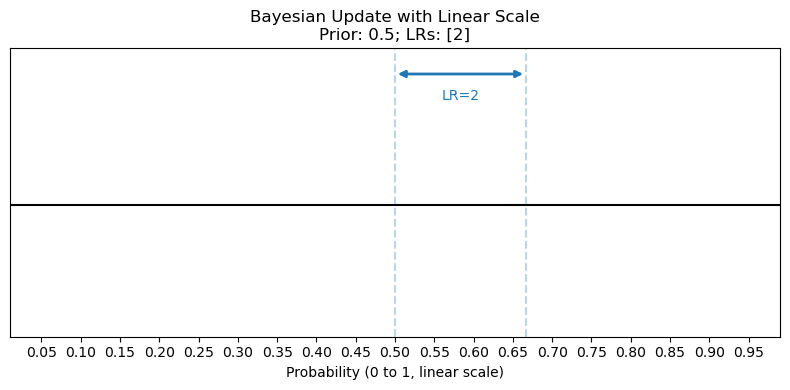

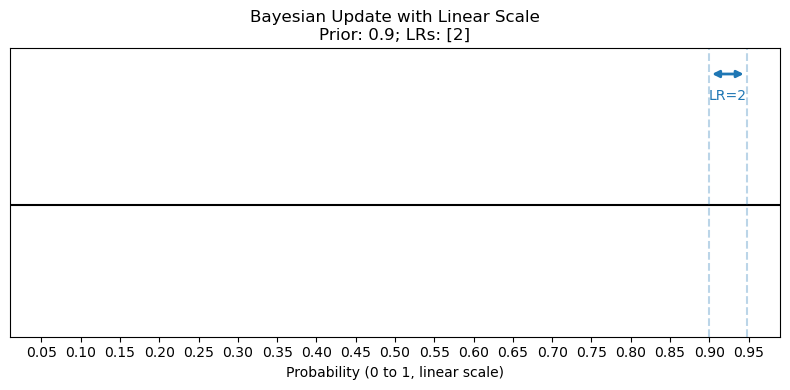

In [2]:
# Helper functions
def probability_to_odds(probability: float) -> float:
    """Convert probability to odds."""
    if np.any(probability < 0) or np.any(probability > 1):
        print(f"Invalid probability encountered: {probability}")
        raise ValueError("Probability must be between 0 and 1 (inclusive).")
    return probability / (1 - probability)

def odds_to_probability(odds: float) -> float:
    """Convert odds to probability."""
    if np.any(odds < 0):        
        print(f"Invalid odds encountered: {odds}")
        raise ValueError("Odds must be non-negative.")
    return odds / (1 + odds)

def bayesian_update_odds(pre_test_odds: float, likelihood_ratio: float) -> float:
    """
    Calculate post-test odds.

    Args:
        pre_test_odds (float): Pre-test odds
        likelihood_ratio (float): Likelihood ratio (positive value).

    Returns:
        float: Post-test odds
    """
    if likelihood_ratio <= 0:
        print(f"Invalid LR encountered: {likelihood_ratio}")
        raise ValueError("Likelihood ratio must be non-negtative.")
    return pre_test_odds * likelihood_ratio

def bayesian_update_prob(pre_test_prob: float, likelihood_ratio: float) -> float:
    """
    Calculate post-test probability.

    Args:
        pre_test_prob (float): Pre-test probability (0 <= pre_test_prob <= 1).
        likelihood_ratio (float): Likelihood ratio (positive value).

    Returns:
        float: Post-test probability.
    """
    if pre_test_prob < 0 or pre_test_prob > 1: 
        print(f"Invalid pre-test probability encountered: {pre_test_prob}")
        raise ValueError("Pre-test probability must be between 0 and 1 (inclusive).")
    if likelihood_ratio <= 0:
        print(f"Invalid LR encountered: {likelihood_ratio}")
        raise ValueError("Likelihood ratio must be non-negtative.")

    pre_test_odds = probability_to_odds(pre_test_prob)
    post_test_odds = bayesian_update_odds(pre_test_odds, likelihood_ratio)
    return odds_to_probability(post_test_odds)

# Program to update demonstrate probability vs odds and log-odds
def bayesian_update_plot(
    prior,
    lrs,
    scale="linear",
    tick_probs=None,
    min_prob=0.01,
    max_prob=0.99,
    figsize=(8, 4)
):
    """
    Generate a plot showing how multiple LRs update a single
    prior probability. Supports linear, probability on a log(odds) scale, and odds scales.
    All inputs are probabilities

    Parameters
    ----------
    prior : float
        Pre-test probability (0 < prior < 1).
    lrs : list of float
        One or more likelihood ratios for individual tests.
    scale : str, optional
        "linear", "log", or "odds". Default is "linear".
    tick_probs : list of float, optional
        Probability values at which to place ticks on the x-axis.
        E.g., [0.01, 0.1, 0.5, 0.9]. The function converts them as needed
        for each scale. If None, defaults are provided per scale.
    min_prob, max_prob : float, optional
        The overall probability range to display on the x-axis (0 to 1).
        If scale="odds" or "log", these will be internally converted to
        odds or log-odds for plotting.
    figsize : tuple of float, optional
        Size of the Matplotlib figure.

    Returns
    -------
    None
        Plots the figure directly.
    """
    # --- Pre-calculate posterior odds ---
    prior_odds = probability_to_odds(prior)
    posteriors_odds = [prior_odds * lr for lr in lrs]
    combined_lr = np.prod(lrs)
    combined_odds = prior_odds * combined_lr

    posteriors_prob = [bayesian_update_prob(prior, lr) for lr in lrs]
    combined_prob = bayesian_update_prob(prior, combined_lr)

    # --- Determine x-axis data, ticks, labels ---
    if scale == "linear":
        x_array = np.linspace(min_prob, max_prob, 200)
        if tick_probs is None:
            tick_probs = np.linspace(min_prob, max_prob, 5)
        x_ticks = tick_probs
        x_tick_labels = [f"{p:.2f}" for p in tick_probs]
        x_label = "Probability (0 to 1, linear scale)"
        x_prior = prior
        x_posteriors = posteriors_prob
        x_combined = combined_prob

    elif scale == "log":
        start_logodds = prob_to_logodds(min_prob)
        end_logodds = prob_to_logodds(max_prob)
        x_array = np.linspace(start_logodds, end_logodds, 200)
        if tick_probs is None:
            tick_probs = [0.01, 0.05, 0.1, 0.5, 0.9, 0.95]
        x_ticks = [prob_to_logodds(tp) for tp in tick_probs]
        x_tick_labels = [f"{tp:.2f}" for tp in tick_probs]
        x_label = "Probability (log-odds scale)"
        x_prior = prob_to_logodds(prior)
        x_posteriors = [prob_to_logodds(p) for p in posteriors_prob]
        x_combined = prob_to_logodds(combined_prob)

    elif scale == "odds":  #same as log, but with odds labels rather than probs
        odds_min = probability_to_odds(min_prob)
        odds_max = probability_to_odds(max_prob)
        x_array = np.logspace(np.log10(odds_min), np.log10(odds_max), 200)
        if tick_probs is None:
            tick_probs = [0.01, 0.1, 0.5, 0.9, 0.99]
        x_ticks_odds = [probability_to_odds(tp) for tp in tick_probs]
        x_ticks = x_ticks_odds
        x_tick_labels = [f"{o:.3g}" for o in x_ticks_odds]
        x_label = "Odds of Disease (log10 axis)"
        x_prior = prior_odds
        x_posteriors = posteriors_odds
        x_combined = combined_odds

    else:
        raise ValueError("Invalid scale. Choose 'linear', 'log', or 'odds'.")

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x_array, np.zeros_like(x_array), 'k-')
    if scale == "odds":
        ax.set_xscale("log")
    ax.set_xlim(x_array[0], x_array[-1])
    ax.set_ylim(-0.15, 0.18)  # Enough vertical space for multiple arrows
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel(x_label)
    ax.set_yticks([])  # Hide y-axis ticks, since we only plot horizontal arrows
    color_list = [f"C{i}" for i in range(len(lrs))]
    for i, (lr, x_post) in enumerate(zip(lrs, x_posteriors)):
        y_arrow = 0.15 - i * 0.05
        color = color_list[i]
        ax.axvline(x=x_prior, color=color, linestyle="--", alpha=0.3)
        ax.axvline(x=x_post, color=color, linestyle="--", alpha=0.3)
        ax.annotate(
            "",
            xy=(x_post, y_arrow),
            xytext=(x_prior, y_arrow),
            arrowprops=dict(arrowstyle="<|-|>", color=color, lw=2),
        )
        ax.text(
            (x_prior + x_post) / 2,
            y_arrow - 0.03,
            f"LR={lr}",
            ha="center",
            color=color
        )
    if len(lrs) > 1:
        y_arrow_combined = 0.15 - len(lrs) * 0.05
        ax.axvline(x=x_prior, color="red", linestyle="--", alpha=0.3)
        ax.axvline(x=x_combined, color="red", linestyle="--", alpha=0.3)
        ax.annotate(
            "",
            xy=(x_combined, y_arrow_combined),
            xytext=(x_prior, y_arrow_combined),
            arrowprops=dict(arrowstyle="<|-|>", color="red", lw=2),
        )
        ax.text(
            (x_prior + x_combined) / 2,
            y_arrow_combined - 0.03,
            f"Combined LR={combined_lr:.1f}",
            ha="center",
            color="red"
        )

    ax.set_title(
        f"Bayesian Update with {scale.capitalize()} Scale\n"
        f"Prior: {prior:.3g}; LRs: {lrs}"
    )
    plt.tight_layout()
    plt.show()

bayesian_update_plot(prior=0.5, lrs=[2], tick_probs = np.linspace(0.05, 0.95, 19), scale="linear")
bayesian_update_plot(prior=0.9, lrs=[2], tick_probs = np.linspace(0.05, 0.95, 19), scale="linear")

So, normalizing in probability space (rather than in log-odds space) implies that you actually updated with a different LR (recall, post-test odds / pre-test odds must equal the Likelihood ratio ). This LR is distorted by an amount that depends on the probability of the diagnosis - not what we want.  

The naive probability normalization dilutes strong (probable) diagnoses and inflates weak (improbable) ones.

Consider: 
- Priors (A- 0.50, B- 0.30, C- 0.20); 
- LLM estimated OVR LRs (4, 3, 2).
- Binary posterior probabilities: (0.800, 0.563, 0.333); sum to 1.696 (!= 1), so non-coherent
- Renormalize in probability space => P=(0.472, 0.332, 0.197).
- Implied OVR LRs from the bayesian update P: (0.893, 1.158, 0.979) — nowhere near (4, 3, 2)! 

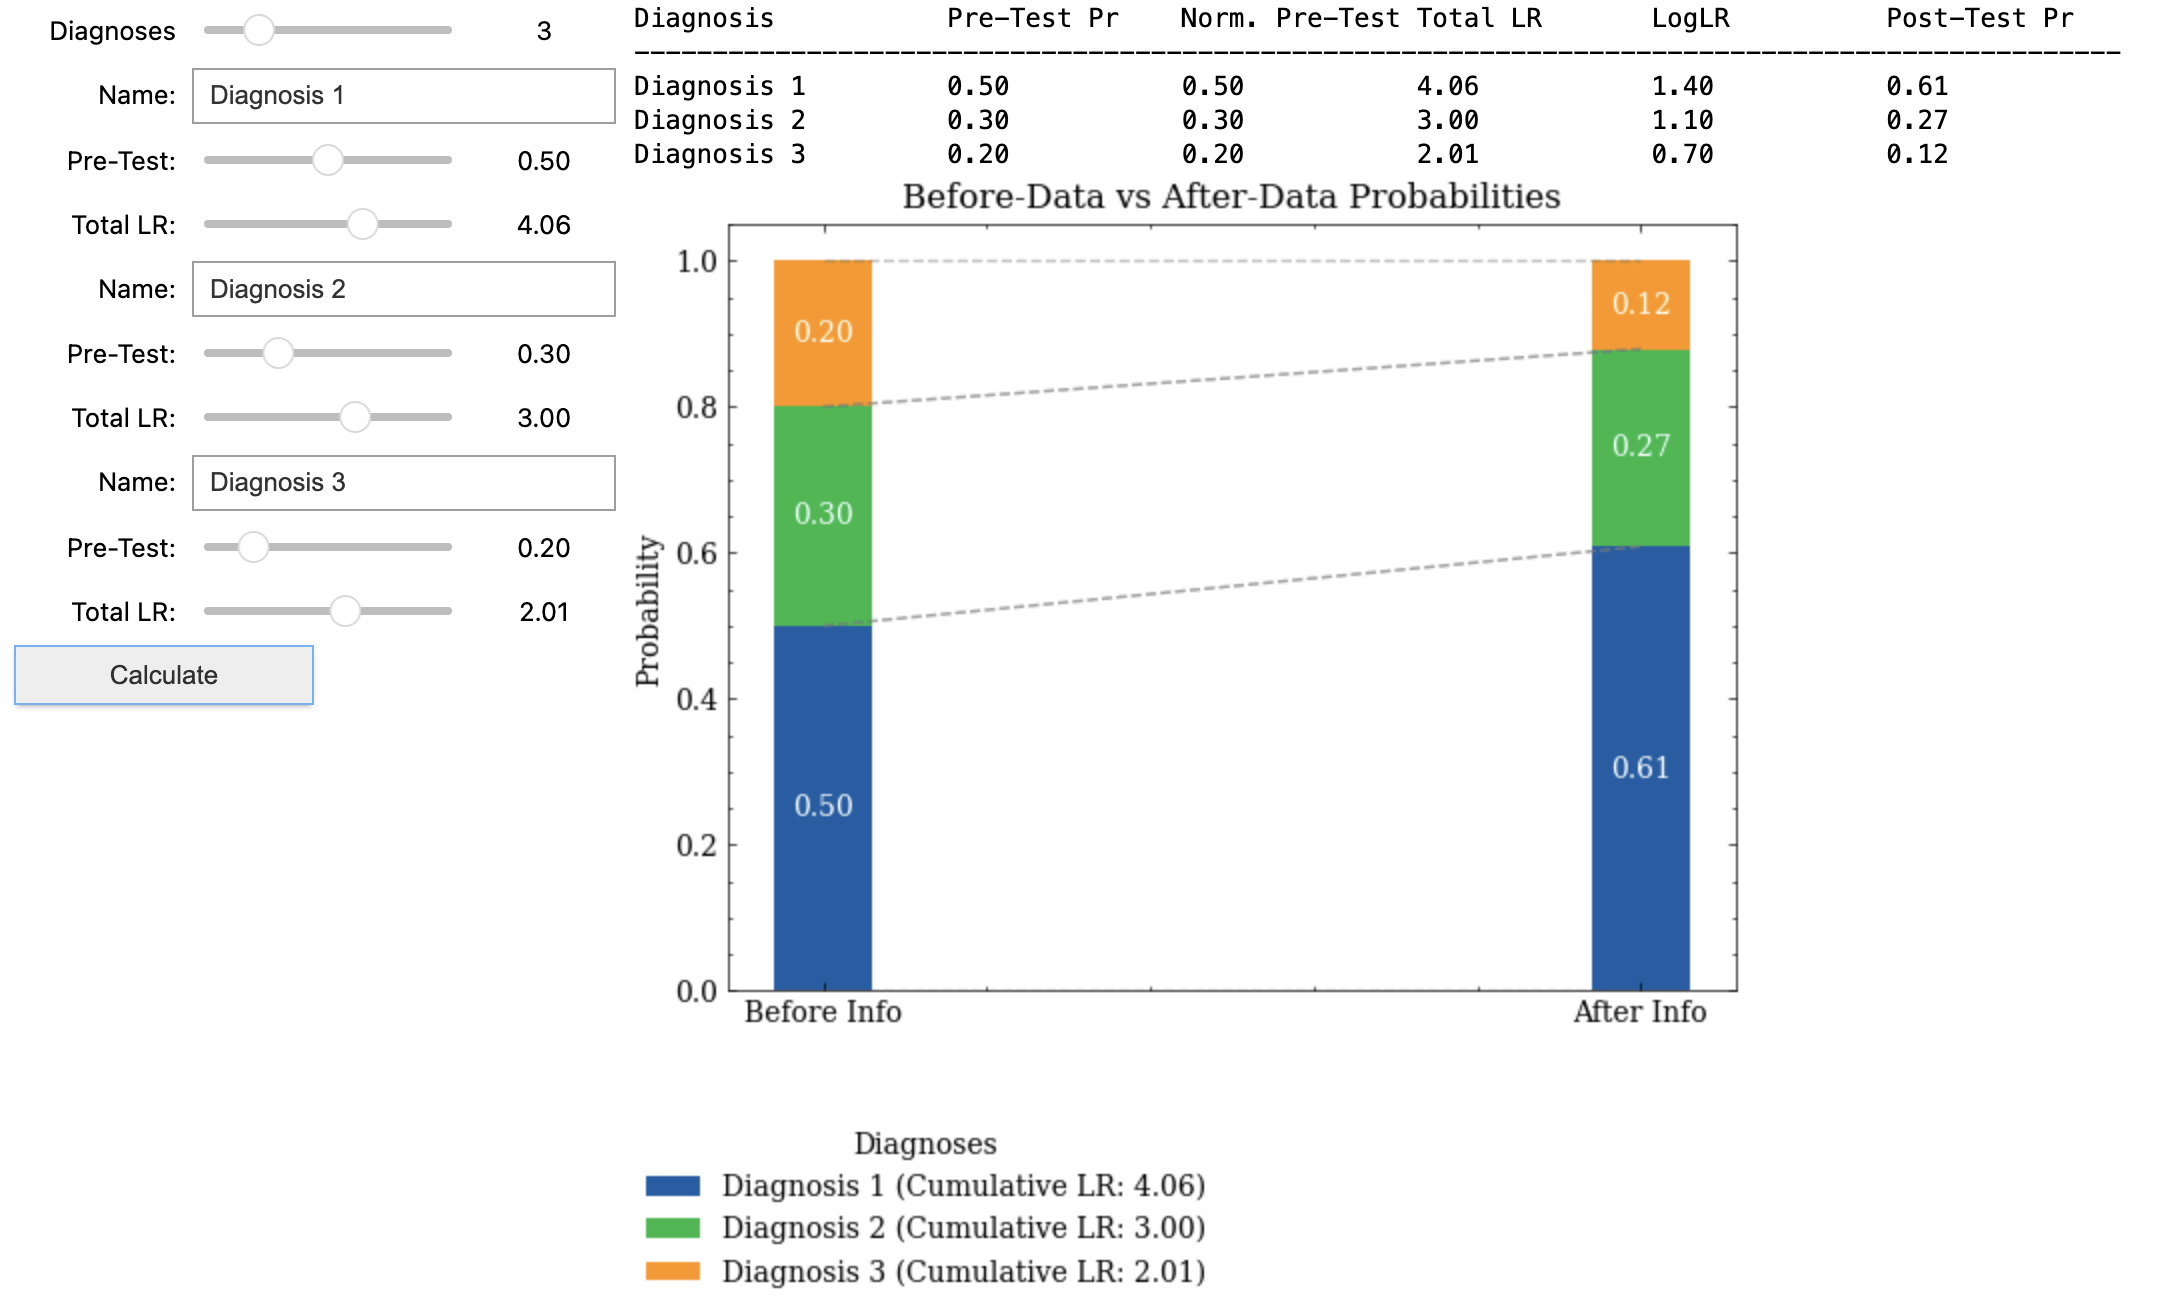


Another way to think about the cohorence issue: In the example above, we've specified that the correct answer is one and only one of the categories. 

With the example LRs of 4, 3, and 2 - this would imply that there's evidence for ***all*** of the diagnoses... but this can't be true, because evidence that one is the correct diagnosis is inherently evidence that the others are not. If LR1 is above 1 (positive), and LR2 is above 1 (positive) then LR3 must be below 1 (negative) because the evidence can't, on net, favor all 3. 

Thus, the "re-normalization" of evidence must re-calibrate the evidence in such a way that the resulting probability distribution is coherent (all probabilities sum to 1), but we'd like to preserve the implied strengths of evidence. 

#### Related algorithms

There are a few well known algorithms that solve similar (but not exactly this) problem: 

- "Softmax regression" can be applied when all the likelihood ratios have the same denominators (ie. with have LRs all referenced to 1 class - LR A vs *C* and LR B vs *C*; or against some reference/marginal likelihood). But, in our casethe LRs we estimate have different denominators (not A, not B, or not C)
- there is a multi-class extension of Bayes theorem using pairwise LRs (ie. LR of A vs B, LR of A vs C, LR of B vs C), but it is not applicable here because we have one-vs-rest LRs (A vs not A, B vs not B), not pairwise LRs.


### Solution - Coherent One-vs-rest LR Projection

So, an alternative way to solve this 'coupling problem' would be to rescale the estimated LRs in log-odds space - adding or subtracting (equivalent to dividing or multiplying in LR space) them all by some factor such that the set of OVR LRs are consistent (== result in post-test probabilities that sum to 1). This would work (it's whats called an intercept‑only calibration; it fixes a global bias but can’t correct class‑specific errors). 

But, an even better approach is to consider that the existing one-vs-rest LR estimates are a best guess. Errors may follow a normal distribution if they result from random additive factors pushing the estimate erroneously in either direction (ie. one thing push the estimate a little too high, another thing pushed it down, etc). In that case, we can take the group of LRs and try to fit a solution set of LRs that minimizes the squared error of the estimates we have, but will result in a post-test probability that sums to 1 (ie. is coherent). This then becomes a constrained optimization problem. 

How the original example would look retinkered, with the Bayes-coherent One-Vs-Rest LR Solver: 
- Prior Probabilities (A- 0.50, B- 0.30, C- 0.20); 
- LLM estimated OVR LRs (4, 3, 2).
- Renormalized OVR LRs (1.08, .99, .905)
- Resulting Post-test probabilities => P=(0.52, 0.3, 0.18).

In essence, we are are fitting class “scores” that define a single multiclass model, under the assumption the inputs have been estimated noisily; the fitted model is the set of LRs that minimizes the squared error to the estimates and is also a coherent set of OVR LRs (ie. a posterior that sums to 1).

That's what the new algorithm does. There is an additional L2 regularization step to ensure that extreme values (ie huge or tiny LRs, very high or lower pretest probabilities) don't make the problem too hard/unstable to numerically solve

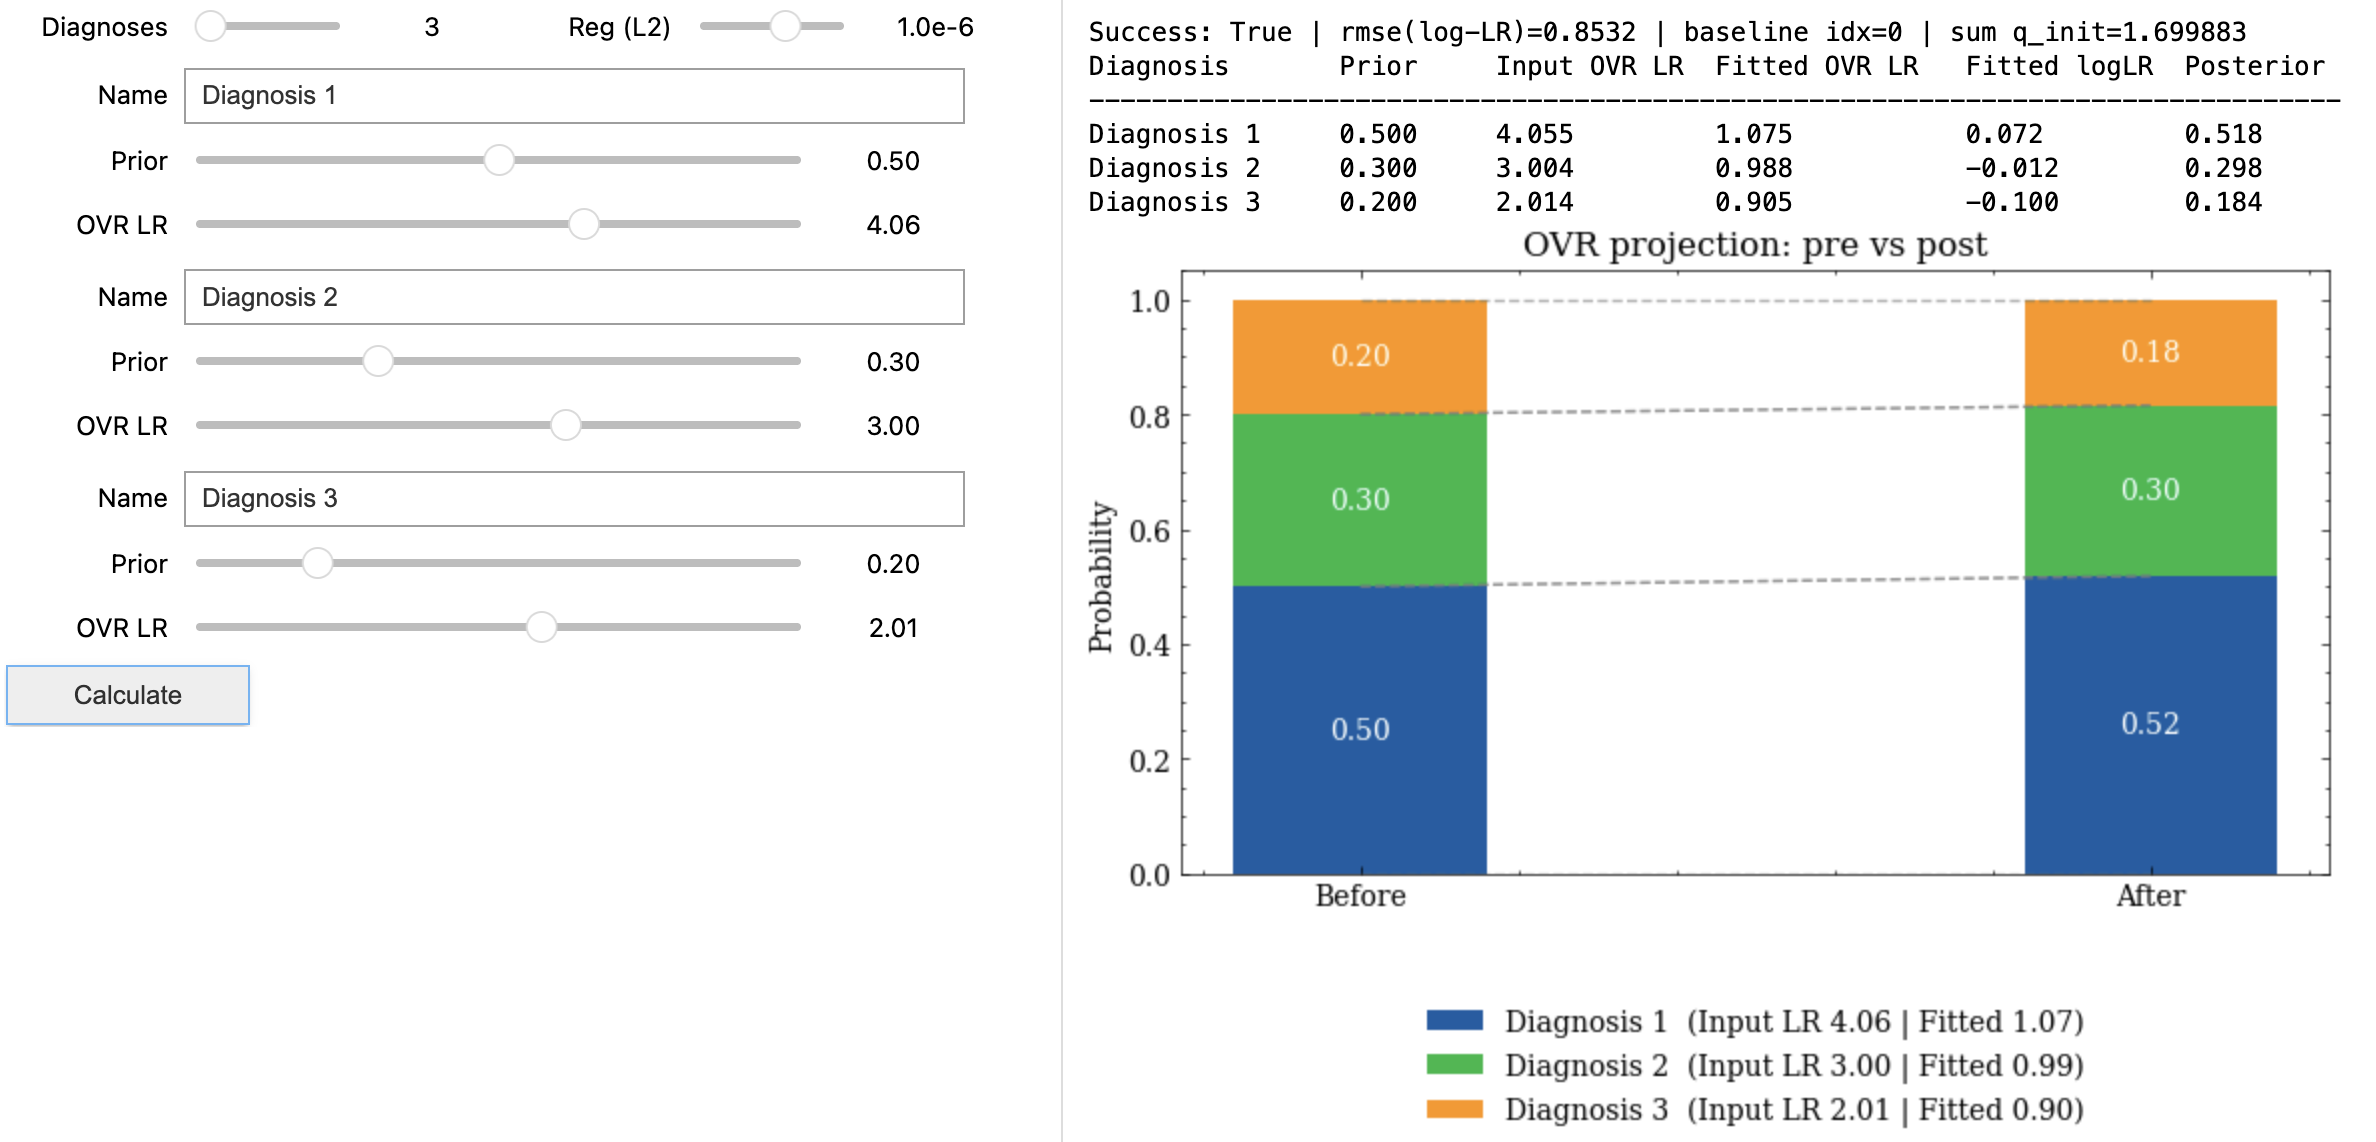


In [3]:
# ==== OVR COHERENT PROJECTION  ======================
# Goal: You have one‑vs‑rest LRs per class (k vs "not‑k"). They may be noisy or
#       mutually inconsistent. This routine "projects" them onto a single,
#       Bayes‑coherent multiclass model by finding class scores (s_k) so that the
#       model's implied one‑vs‑rest (OVR) LRs are as close as possible (least squares).
#       The resulting posterior probabilities are coherent (they form one distribution).

import numpy as np, matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Optional, Dict, Any
from scipy.optimize import least_squares
from scipy.special import expit, logsumexp


# ---------- Structured result ----------
@dataclass
class OVRProjectionResult:
    posterior: np.ndarray                 # Coherent P_k (sums to 1)
    log_scores: np.ndarray                # Fitted class "scores" s_k (one class fixed to 0)
    fitted_ovr_lr: np.ndarray             # Model-implied OVR LRs (so you can see what changed)
    rmse_logLR: float                     # How close we matched your inputs (log-LR RMSE)
    success: bool
    message: str
    diagnostics: Dict[str, Any]           # Extras: baseline index, sum_q_init, priors, inputs, ...


# ---------- Core solver ----------
def ovr_project_posterior(priors, ovr_lr, reg: float = 1e-6, weights: Optional[np.ndarray] = None,
                          baseline: Optional[int] = None) -> OVRProjectionResult:
    """
    What this function does:
    ------------------------------------------
    • Residuals = current misfits: for each class, "your OVR log‑LR" minus
      "what the current model says that OVR log‑LR should be".
      We want all misfits near zero (least squares).

    • Jacobian = sensitivity table: if we nudge each class score a little,
      how will each misfit change? Rows = misfits; columns = scores.
      Using this table, the solver takes purposeful steps that reduce all misfits together.

    • Steps:
      1) Normalize/guard inputs (priors ∈ (0,1), LRs > 0).
      2) Build an initial guess for scores from each class’s own binary update.
      3) Iterate: compute misfits + Jacobian, choose a small score update that most
         reduces total misfit (with ridge to keep steps stable), repeat.
      4) Return the coherent posterior and the model‑implied OVR LRs.

    Returns a dataclass with: posterior, fitted scores, fitted OVR LRs, and diagnostics.
    """
    # -- Sanitize inputs: safe ranges, normalized priors
    pi = np.asarray(priors, float).clip(1e-12, 1-1e-12)
    pi /= pi.sum()
    lam = np.asarray(ovr_lr, float)
    K = pi.size
    if K < 2: raise ValueError("Need at least 2 classes.")
    if lam.size != K: raise ValueError("priors and ovr_lr must have same length.")
    if np.any(lam <= 0): raise ValueError("All OVR LRs must be > 0.")
    # Fix one class as a reference so scores are identifiable (adding a constant to all s_k changes nothing)
    if baseline is None: baseline = int(np.argmax(pi))
    # Optional confidence per class (all ones by default)
    w = np.ones(K) if weights is None else np.asarray(weights, float).clip(1e-12, None)

    # -- Precompute logs (stable + fast to reuse)
    log_pi = np.log(pi)
    log1m = np.log(1 - pi)          # log(1 - prior)
    log_lambda = np.log(lam)        # work in evidence units (log‑LR)
    logit_pi = log_pi - np.log(1 - pi)

    # -- Initial guess: each class’s own binary posterior slice q0 (k vs not‑k)
    #    If inputs are already coherent, these slices will already tile the pie (sum ≈ 1).
    q0 = expit(logit_pi + log_lambda)

    # Convert those slices to initial scores s0:
    # (Posterior looks like prior_k * exp(score_k), up to a constant shift.)
    s0 = (np.log(q0) - np.log(pi))
    s0 -= s0[baseline]              # pin the baseline score to 0
    keep = np.array([i for i in range(K) if i != baseline])  # optimize only non‑baseline entries
    theta0 = s0[keep]

    def unpack(theta):
        """Rebuild the full score vector from optimized entries (baseline stays at 0)."""
        s = np.empty(K); s[baseline] = 0.0; s[keep] = theta; return s

    # -- Define: residuals (misfits) and Jacobian (sensitivity table)
    def residual_and_jac(theta):
        """
        Residuals:
          For each class, compare your provided OVR log‑LR to the model’s OVR log‑LR
          computed with the current scores and the proper "rest" mixture.
        Jacobian:
          How each residual would change if we nudge each score slightly
          (diagonals = own class effect; off‑diagonals = cross‑effects via the rest mixture).
        """
        s = unpack(theta)

        # Current unnormalized "support" per class: log(prior_k) + score_k
        z = log_pi + s

        # Stable exponentiation (log‑sum‑exp trick)
        m = np.max(z)
        ez = np.exp(z - m)          # proportional to prior_k * exp(score_k)
        S  = ez.sum()

        # Proper denominator for "k vs not‑k": sum of all OTHER classes' support
        Sminus = np.maximum(S - ez, 1e-12)
        logSminus = np.log(Sminus) + m

        # Model‑implied OVR log‑LR for each class (what the current scores imply)
        model_loglr = s - logSminus + log1m

        # Residuals on log‑LR scale (what you gave minus what the model implies), with optional weights
        r = np.sqrt(w) * (log_lambda - model_loglr)

        # Jacobian: sensitivity of each residual to each score
        J = np.zeros((K, K))
        np.fill_diagonal(J, -np.sqrt(w))      # own score strongly moves own residual
        # Cross‑talk: changing class j changes the "rest of k" mixture and thus k's residual
        frac = ez[None, :] / Sminus[:, None]
        frac[np.arange(K), np.arange(K)] = 0.0
        J += (np.sqrt(w)[:, None] * frac)
        # We only optimize non‑baseline scores
        J = J[:, keep]

        # Ridge: add gentle pull toward 0 (stability / prevents runaway scores in inconsistent inputs)
        if reg > 0:
            r = np.concatenate([r, np.sqrt(reg) * theta])
            J = np.vstack([J, np.sqrt(reg) * np.eye(theta.size)])
        return r, J

    # -- Solve the small least‑squares problem iteratively, using the Jacobian as the slope map
    res = least_squares(lambda t: residual_and_jac(t)[0],
                        theta0, jac=lambda t: residual_and_jac(t)[1],
                        method="trf", ftol=1e-10, xtol=1e-10, gtol=1e-10, max_nfev=200)

    # -- Turn fitted scores into a coherent posterior (one shared denominator)
    theta = res.x
    s_hat = unpack(theta)
    z_hat = log_pi + s_hat
    posterior = np.exp(z_hat - logsumexp(z_hat))

    # -- Report, for transparency, the OVR LRs implied by the fitted coherent model
    ez = np.exp(z_hat)
    S = ez.sum()
    Sminus = np.maximum(S - ez, 1e-12)
    model_loglr = s_hat - np.log(Sminus) + log1m
    lam_fit = np.exp(model_loglr)

    return OVRProjectionResult(
        posterior=posterior,
        log_scores=s_hat,
        fitted_ovr_lr=lam_fit,
        rmse_logLR=float(np.sqrt(np.mean(res.fun**2))),
        success=bool(res.success),
        message=res.message,
        diagnostics={
            "baseline": baseline,
            # Quick sanity: if inputs were coherent already, sum(q0) ≈ 1
            "sum_q_init": float(q0.sum()),
            "priors": pi,
            "input_ovr_lr": lam
        }
    )

And here's code for a visualizer

In [4]:
from ipywidgets import VBox, HBox, IntSlider, Text, FloatSlider, FloatLogSlider, Output, Button, Layout
# Optional, pretty style (safe if not installed)
try:
    import scienceplots; plt.style.use('science')
    plt.rcParams['text.usetex'] = False
except Exception:
    pass

# ---------- Minimal plotting & UI ----------

def run_once_ovr(names, priors, ovr_lrs, reg=1e-6):
    pri = np.asarray(priors, float)
    if pri.sum() <= 0: raise ValueError("Sum of priors must be > 0")
    pri = pri / pri.sum()
    res = ovr_project_posterior(pri, np.asarray(ovr_lrs, float), reg=reg)
    print(f"Success: {res.success} | rmse(log-LR)={res.rmse_logLR:.4g} | baseline idx={res.diagnostics['baseline']} | sum q_init={res.diagnostics['sum_q_init']:.6f}")
    print(f"{'Diagnosis':<16}{'Prior':<10}{'Input OVR LR':<14}{'Fitted OVR LR':<16}{'Fitted logLR':<14}{'Posterior':<10}")
    print("-"*80)
    for i, nm in enumerate(names):
        print(f"{nm:<16}{pri[i]:<10.3f}{ovr_lrs[i]:<14.3f}{res.fitted_ovr_lr[i]:<16.3f}{np.log(res.fitted_ovr_lr[i]):<14.3f}{res.posterior[i]:<10.3f}")
    plot_pre_post(priors, res.posterior, names, np.log(ovr_lrs), res.fitted_ovr_lr)

def plot_pre_post(pre, post, names, input_loglr, fitted_ovr_lr):
    """
    Stacked 'Before' vs 'After' bars with dashed connectors for each class segment.
    Legend shows Input vs Fitted OVR LR.
    """
    pre = np.asarray(pre, float); pre = pre / pre.sum()
    post = np.asarray(post, float); post = post / post.sum()

    x = np.array([0, 1])              # x-positions: Before, After
    width = 0.32

    fig, ax = plt.subplots(figsize=(6.5, 5.0))
    bottom = np.zeros(2)

    # keep segment boundaries for connectors
    top_before, top_after = [], []
    bot_before, bot_after = [], []

    for i, nm in enumerate(names):
        vals = np.array([pre[i], post[i]], float)

        # record boundaries BEFORE stacking this segment
        bot_before.append(bottom[0]); bot_after.append(bottom[1])
        top_before.append(bottom[0] + vals[0]); top_after.append(bottom[1] + vals[1])

        bars = ax.bar(x, vals, bottom=bottom, width=width,
                      label=f"{nm}  (Input LR {np.exp(input_loglr[i]):.2f} | Fitted {fitted_ovr_lr[i]:.2f})")
        for j, b in enumerate(bars):
            ax.text(b.get_x()+b.get_width()/2, b.get_y()+b.get_height()/2,
                    f"{vals[j]:.2f}", ha="center", va="center", color="white")
        bottom += vals

    # dashed connectors between corresponding boundaries
    for i in range(len(names)):
        ax.plot(x, [top_before[i], top_after[i]], linestyle="--", color="gray", alpha=0.6, lw=1)
        ax.plot(x, [bot_before[i], bot_after[i]], linestyle="--", color="gray", alpha=0.6, lw=1)

    ax.set_xticks(x); ax.set_xticklabels(["Before", "After"])
    ax.set_ylabel("Probability")
    ax.set_title("OVR projection: pre vs post")
    ax.legend(bbox_to_anchor=(0.5, -0.18), loc="upper center", ncol=1)
    plt.tight_layout()
    plt.show()


def make_widget_ovr():
    """
    Controls on the LEFT; output (table + plot) on the RIGHT.
    """
    # controls
    n_slider  = IntSlider(value=3, min=2, max=12, step=1, description="Diagnoses",
                          layout=Layout(width="280px"))
    reg_slider = FloatLogSlider(value=1e-6, base=10, min=-12, max=-2, step=0.5,
                                description="Reg (L2)", readout_format=".1e",
                                layout=Layout(width="280px"))

    # container for per-class rows (scrollable if long)
    box = VBox(layout=Layout(overflow_y="auto", max_height="420px", width="100%"))
    out = Output(layout=Layout(width="60%", border="1px solid #ddd", padding="8px",
                               min_height="520px"))
    # left panel (fixed width so right output sits beside it)
    left = VBox(layout=Layout(width="38%", min_width="340px"))

    def rebuild(_):
        rows = []
        for i in range(n_slider.value):
            name = Text(value=f"Diagnosis {i+1}", description="Name", layout=Layout(width="95%"))
            prior = FloatSlider(value=0.33, min=0, max=1, step=0.01, description="Prior",
                                readout_format=".2f", layout=Layout(width="95%"))
            lr = FloatLogSlider(value=1.0, base=np.e, min=-5, max=5, step=0.1,
                                description="OVR LR", readout_format=".2f", layout=Layout(width="95%"))
            rows.append(VBox([name, prior, lr], layout=Layout(padding="2px 0")))
        box.children = tuple(rows)

    n_slider.observe(rebuild, 'value')
    rebuild(None)

    # button action: compute and render to the RIGHT
    def compute(_):
        from math import log
        names, priors, lrs = [], [], []
        for c in box.children:
            names.append(c.children[0].value)
            priors.append(c.children[1].value)
            lrs.append(float(c.children[2].value))
        out.clear_output()
        with out:
            # assumes you already have run_once_ovr(...) defined in this notebook
            run_once_ovr(names, priors, lrs, reg=float(reg_slider.value))

    btn = Button(description="Calculate", layout=Layout(width="120px"))
    btn.on_click(compute)

    # assemble left and right
    left.children = (HBox([n_slider, reg_slider]), box, btn)
    ui = HBox([left, out], layout=Layout(align_items="flex-start", justify_content="space-between"))
    return ui

# re-render the widget
display(make_widget_ovr())

In practice, there is no difference between the old, naive algorithm and the new One-vs-rest Coherent Solver when the LR estimates are coherent to start. 

The difference is largest when: 

 - there is a large coherence gap (e.g. the LR estimates would lead to a cumulative posterior probability much different from 1, as in the 4,3,2 example). In that case, the resulting cumulative probability is much over 1, essentially implying that the LRs have "over-claimed evidence". You can imagine an example where the cumulative probability is less than 1, in which case the LRs have "underclaimed evidence".
 - the dominant diagnosis is close to 1 and the LR's claim too much evidence (in which case, the naïve renorm over‑dilutes the leader because the post‑hoc scaling hits it hardest, while OVR‑projection typically preserves more mass on the leader while fixing coherence.)
 - there are unlikely diagnoses and the LR's have underclaimed evidence (in which case, the naive version global up‑scaling affects tails most. OVR‑projection increases them only as much as the rest‑mixture constraints allow.)
 - Skewed priors - With uneven priors, each “not‑k” mixture is very different across classes. Naïve renorm ignores mixture composition; OVR‑projection enforces it. Expect larger gaps as prior skew increases.
 - Conflicting strong LRs - If several classes each claim strong positive evidence, the naïve renorm knocks them all down by the same probability factor. OVR‑projection allocates asymmetrically using priors and the mixture coupling, so results diverge.
 - Heterogenous LR noise/bias - If some OVR LRs are worse than others, naïve renorm can amplify those errors (it cannot correct class‑specific misfit). OVR‑projection absorbs miscalibration via the joint least‑squares fit (plus L2), provided errors aren’t aligned in the same direction.
 - Many diseases on the differential (will make it more likely for there to be a large coherence gap, and/or more unlikely diagnoses)
 - Extremely strong evidence (ie very large or small LRs) - Near 0/1, logistic updates are highly non‑linear. Naïve renorm can even flip the implied LR direction for some classes; OVR‑projection resists such flips unless forced by coherence.